In [416]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# RUN BLR

In [417]:
! rm -r '/Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/'
! mkdir '/Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/'

In [447]:
import os
os.chdir('/Users/ltran/Documents/TrueData29/CPC_ML_tutorial/')

import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
import random

from scipy.stats import fisher_exact
from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix
from nm_utils import calibration_descriptives, remove_bad_subjects, load_2d
from sklearn.model_selection import train_test_split
# Set data directory
data_dir = '/Users/ltran/Documents/Data/'

# Set working directory
root_dir = '/Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/'
out_dir = os.path.join(root_dir,'models','test')

# create the output directory if it does not already exist
os.makedirs(out_dir, exist_ok=True)

## Load DF_ALL

In [448]:
df_all = pd.read_csv(os.path.join(data_dir, 'Outputs/df_abide.csv'))

### Define ROI

In [449]:
all_cols = [col for col in df_all.columns if '_thickness' in col]
# all_cols.remove('lh_MeanThickness_thickness')
# all_cols.remove('rh_MeanThickness_thickness')

In [450]:
len(all_cols)

68

In [451]:
idp_ids = all_cols

## Plot data

In [452]:
import joypy
from matplotlib import cm

Text(0.5, 18.5, 'Age')

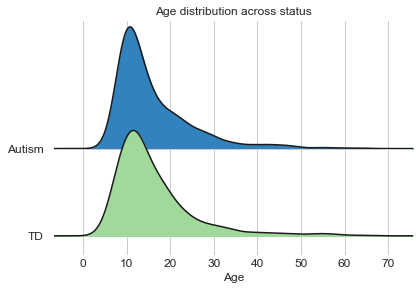

In [453]:
fig, axes = joypy.joyplot(df_all[['age_at_scan', 'ASD']].replace({'No' : 'TD', 'Yes' : 'Autism'}),  by = 'ASD', grid = True, 
                             title = 'Age distribution across status',
                             ylim = 'max',
                             colormap = cm.tab20c)

plt.xlabel('Age')

Text(0.5, 18.5, 'Age')

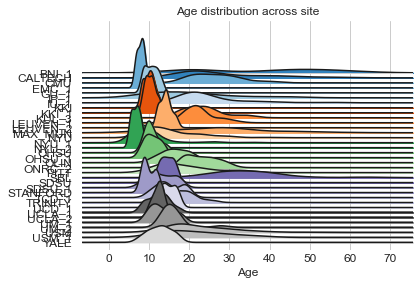

In [454]:
fig, axes = joypy.joyplot(df_all[['age_at_scan', 'site']].replace({'No' : 'TD', 'Yes' : 'Autism'}),  by = 'site', grid = True, 
                             title = 'Age distribution across site',
                             ylim = 'max',
                             colormap = cm.tab20c)

plt.xlabel('Age')

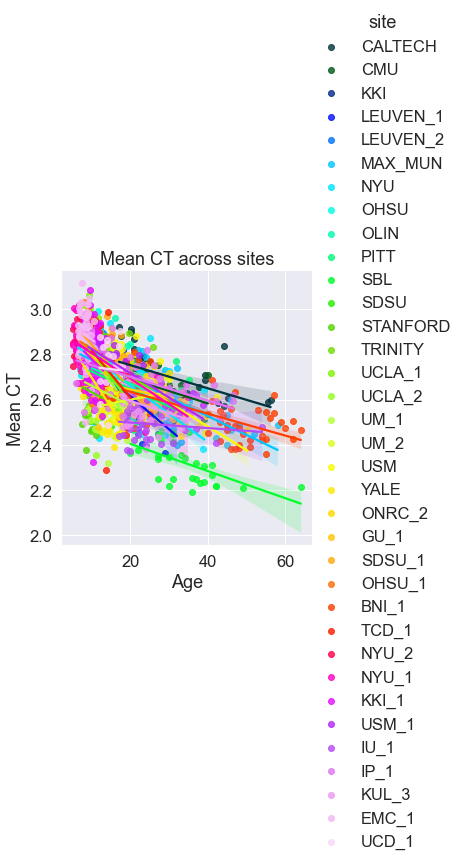

In [455]:
df_all_avg = df_all.copy()
df_all_avg['AVG'] = df_all_avg[all_cols].mean(axis  =1)
sns.set_theme(style="darkgrid",font_scale=1.5)
c = sns.lmplot(data=df_all_avg, x="age_at_scan", y='AVG', hue="site",
              palette = 'gist_ncar').set(xlabel = 'Age', ylabel = 'Mean CT', title = 'Mean CT across sites')

plt.show()

# Run BLR

In [456]:
pred_bool = input("Prediction on TD + ASD : 1 \nPrediction on ASD only : 2\n")

Prediction on TD + ASD : 1 
Prediction on ASD only : 2
1


In [457]:
# Metric DataFrame
metric_analysis = pd.DataFrame(columns = ['ROIs', 'EV mean', 'EV max', 'MSLL mean', 'MSLL min', 'Covs', 'Fixed effect', 'xmin', 'xmax', 'Outlier Thresh'])



In [458]:
# Choosing covariates
cols_cov = ['age_at_scan','sex']

fixed_effect = 'NA'

# Type of Warping 
warp =  'WarpSinArcsinh'


# B-Spline limits
xmin = round(df_all['age_at_scan'].min() - 5) # ~ age min - 5 
xmax = round(df_all['age_at_scan'].max() + 5) # ~ age max + 5

force_refit = True 

# Threshold for outliers
outlier_thresh = 5

In [459]:
# DataFrame with only TD
df_td = df_all.loc[df_all.ASD == 'No']
df_asd = df_all.loc[df_all.ASD == 'Yes']
df_relatives = df_all.loc[df_all.ASD == 'Relative']

strat = ['age_at_scan', 'sex', 'site']
if (pred_bool == '1'):
    
    

    #Split train & test, stratified by site
    df_sx, df_tex1, df_sy, df_tey1 = train_test_split(df_td[strat], df_td[idp_ids], 
                                                        test_size=0.5, 
                                                        random_state=42,
                                                       stratify = df_td[['site']])

    df_trx, df_tex2, df_try, df_tey2 = train_test_split(df_sx, df_sy, 
                                                       test_size = 0.5, random_state=42, 
                                                      stratify = df_sx[['site']])

    df_te1 = df_tex1.join(df_tey1)
    df_te2 = df_tex2.join(df_tey2)
    df_te2 = df_te2.join(df_all, how = 'left', lsuffix = '', rsuffix='r')
    df_tr = df_trx.join(df_try)
    df_te3 = pd.concat([df_te2, df_asd, df_relatives])
elif (pred_bool == '2'):
    
    df_sx, df_tex1, df_sy, df_tey1 = train_test_split(df_td[strat], df_td[idp_ids], 
                                                    test_size=0.5, 
                                                    random_state=42,
                                                   stratify = df_td[ 'site'])
    df_tr = df_sx.join(df_sy)
    df_te1 = df_tex1.join(df_tey1)
    df_te3 = df_asd.copy()

In [470]:
df_all

site  participant_id  dx_group  age_at_scan  sex handedness_category  \
0     CALTECH           51456         1         55.4    1                   R   
1     CALTECH           51457         1         22.9    1                Ambi   
2     CALTECH           51458         1         39.2    1                   R   
3     CALTECH           51459         1         22.8    1                   R   
4     CALTECH           51460         1         34.6   -1                Ambi   
...       ...             ...       ...          ...  ...                 ...   
2075   OHSU_1           30163         2          8.0   -1                 1.0   
2076   OHSU_1           30164         2         10.0   -1                 1.0   
2077   OHSU_1           30165         2         12.0   -1                 1.0   
2078   OHSU_1           30166         2         10.0   -1                 1.0   
2079   OHSU_1           30167         2         14.0   -1                 1.0   

      handedness_scores    fiq    viq    piq  ...  \
0                   NaN  126.0  118.0  128.0  ...   
1                   NaN  107.0  119.0   93.0  ...   
2                   NaN   93.0   80.0  108.0  ...   
3                   NaN  106.0   94.0  118.0  ...   
4                   NaN  133.0  135.0  122.0  ...   
...                 ...    ...    ...    ...  ...   
2075              81.25  136.0    NaN    NaN  ...   
2076             100.00  115.0    NaN    NaN  ...   
2077             100.00  120.0    NaN    NaN  ...   
2078             100.00  112.0    NaN    NaN  ...   
2079             100.00  100.0    NaN    NaN  ...   

     lh_rostralmiddlefrontal_thickness lh_superiorfrontal_thickness  \
0                                2.498                        2.837   
1                                2.589                        2.757   
2                                2.730                        2.834   
3                                2.823                        3.016   
4                                2.536                        2.811   
...                                ...                          ...   
2075                             2.610                        3.123   
2076                             2.696                        3.017   
2077                             2.660                        3.033   
2078                             2.725                        3.030   
2079                             2.560                        3.026   

     lh_superiorparietal_thickness  lh_superiortemporal_thickness  \
0                            2.204                          2.833   
1                            2.288                          2.970   
2                            2.417                          3.056   
3                            2.555                          3.038   
4                            2.138                          2.864   
...                            ...                            ...   
2075                         2.514                          3.405   
2076                         2.501                          3.099   
2077                         2.480                          2.953   
2078                         2.453                          3.045   
2079                         2.446                          3.098   

      lh_supramarginal_thickness  lh_frontalpole_thickness  \
0                          2.570                     2.786   
1                          2.469                     2.708   
2                          2.707                     2.486   
3                          2.860                     3.419   
4                          2.528                     3.049   
...                          ...                       ...   
2075                       2.916                     2.826   
2076                       2.815                     2.950   
2077                       2.853                     2.791   
2078                       2.860                     2.969   
2079                       2.761   

In [480]:
df_te2 = df_tex2.join(df_tey2).join(df_all[['ASD', 'participant_id']])

In [484]:
df_te3 = pd.concat([df_te2, df_asd, df_relatives])

In [460]:
site_ids = set(df_all['site'])
site_ids_tr = set(df_tr['site'])
site_ids_te = set(df_te1['site'])


for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')

    # set output dir 
    idp_dir = os.path.join(out_dir, idp)
    os.makedirs(os.path.join(idp_dir), exist_ok=True)
    os.chdir(idp_dir)

    # extract the response variables for training and test set
    y_tr = df_tr[idp].to_numpy() 
    y_te = df_te1[idp].to_numpy()

    # remove gross outliers and implausible values
    yz_tr = (y_tr - np.mean(y_tr)) / np.std(y_tr)
    yz_te = (y_te - np.mean(y_te)) / np.std(y_te)
    nz_tr = np.bitwise_and(np.abs(yz_tr) < outlier_thresh, y_tr > 0)
    nz_te = np.bitwise_and(np.abs(yz_te) < outlier_thresh, y_te > 0)
    y_tr = y_tr[nz_tr]
    y_te = y_te[nz_te]

    # write out the response variables for training and test
    resp_file_tr = os.path.join(idp_dir, 'resp_tr.txt')
    resp_file_te = os.path.join(idp_dir, 'resp_te.txt') 
    np.savetxt(resp_file_tr, y_tr)
    np.savetxt(resp_file_te, y_te)

    # configure the design matrix
    X_tr = create_design_matrix(df_tr[cols_cov].loc[nz_tr], 
                                site_ids = df_tr['site'].loc[nz_tr],
                                basis = 'bspline', 
                                xmin = xmin, 
                                xmax = xmax)
    X_te = create_design_matrix(df_te1[cols_cov].loc[nz_te], 
                                site_ids = df_te1['site'].loc[nz_te], 
                                all_sites=site_ids,
                                basis = 'bspline', 
                                xmin = xmin, 
                                xmax = xmax)

    # configure and save the covariates
    cov_file_tr = os.path.join(idp_dir, 'cov_bspline_tr.txt')
    cov_file_te = os.path.join(idp_dir, 'cov_bspline_te.txt')
    np.savetxt(cov_file_tr, X_tr)
    np.savetxt(cov_file_te, X_te)

    if not force_refit and os.path.exists(os.path.join(idp_dir, 'Models', 'NM_0_0_estimate.pkl')):
        print('Making predictions using a pre-existing model...')
        suffix = 'predict'

        # Make prdictsion with test data
        predict(cov_file_te, 
                alg='blr', 
                respfile=resp_file_te, 
                model_path=os.path.join(idp_dir,'Models'),
                outputsuffix=suffix)
    else:
        print('Estimating the normative model...')
        estimate(cov_file_tr, resp_file_tr, testresp=resp_file_te, 
                 testcov=cov_file_te, alg='blr', optimizer = 'l-bfgs-b', 
                 savemodel=True, warp=warp, warp_reparam=True)
        suffix = 'estimate'
blr_metrics = pd.DataFrame(columns = ['eid', 'NLL', 'EV', 'MSLL', 'BIC','Skew','Kurtosis'])

for idp_num, idp in enumerate(idp_ids): 
    idp_dir = os.path.join(out_dir, idp)

    # load the predictions and true data. We use a custom function that ensures 2d arrays
    # equivalent to: y = np.loadtxt(filename); y = y[:, np.newaxis]
    yhat_te = load_2d(os.path.join(idp_dir, 'yhat_' + suffix + '.txt'))
    s2_te = load_2d(os.path.join(idp_dir, 'ys2_' + suffix + '.txt'))
    y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))

    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 

    # compute error metrics
    if warp is None:
        metrics = evaluate(y_te, yhat_te)  

        # compute MSLL manually as a sanity check
        y_tr_mean = np.array( [[np.mean(y_tr)]] )
        y_tr_var = np.array( [[np.var(y_tr)]] )
        MSLL = compute_MSLL(y_te, yhat_te, s2_te, y_tr_mean, y_tr_var)         
    else:
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
        W = nm.blr.warp

        # warp predictions
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]

        # evaluation metrics
        metrics = evaluate(y_te, med_te)

        # compute MSLL manually
        y_te_w = W.f(y_te, warp_param)
        y_tr_w = W.f(y_tr, warp_param)
        y_tr_mean = np.array( [[np.mean(y_tr_w)]] )
        y_tr_var = np.array( [[np.var(y_tr_w)]] )
        MSLL = compute_MSLL(y_te_w, yhat_te, s2_te, y_tr_mean, y_tr_var)     

    Z = np.loadtxt(os.path.join(idp_dir, 'Z_' + suffix + '.txt'))
    [skew, sdskew, kurtosis, sdkurtfddfosis, semean, sesd] = calibration_descriptives(Z)

    BIC = len(nm.blr.hyp) * np.log(y_tr.shape[0]) + 2 * nm.neg_log_lik

    blr_metrics.loc[len(blr_metrics)] = [idp, nm.neg_log_lik, metrics['EXPV'][0], 
                                         MSLL[0], BIC, skew, kurtosis]

display(blr_metrics)

blr_metrics.to_csv(os.path.join(out_dir,'blr_metrics.csv'))
new_row = {'ROIs' : len(idp_ids) , 'EV mean': blr_metrics['EV'].mean(), 'EV max' : blr_metrics['EV'].max() , 'MSLL mean': blr_metrics['MSLL'].mean(), 'MSLL min' : blr_metrics['MSLL'].min(), 'Covs' : cols_cov, 'Fixed effect' : fixed_effect , 'xmin' : xmin, 'xmax' : xmax, 'Outlier Thresh' : outlier_thresh}
metric_analysis = metric_analysis.append(new_row, ignore_index=True)

Running IDP 0 rh_bankssts_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_bankssts_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 1 rh_caudalanteriorcingulate_thickness :


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.29567e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.46822e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.07435e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.07945e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_caudalanteriorcingulate_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 2 rh_caudalmiddlefrontal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_caudalmiddlefrontal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 3 rh_cuneus_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_cuneus_thickness/resp_tr.txt


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.30939e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.96003e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.25822e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.21075e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.96791e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.12267e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.55482e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 4 rh_entorhinal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_entorhinal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 5 rh_fusiform_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_fusiform_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.27085e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.22175e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.05324e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.70569e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 6 rh_inferiorparietal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_inferiorparietal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 7 rh_inferiortemporal_thickness :


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.60742e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.03275e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.92752e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.73601e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_inferiortemporal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 8 rh_isthmuscingulate_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_isthmuscingulate_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.75654e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.96717e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.03707e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 9 rh_lateraloccipital_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_lateraloccipital_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 10 rh_lateralorbitofrontal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_lateralorbitofrontal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 11 rh_lingual_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_lingual_thickness/resp_tr.txt
Estimating mod

/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.20855e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.07169e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.82112e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 12 rh_medialorbitofrontal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_medialorbitofrontal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 13 rh_middletemporal_thickness :


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.88654e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.43018e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.53566e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.90614e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_middletemporal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 14 rh_parahippocampal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_parahippocampal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.40249e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.15498e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.51642e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 15 rh_paracentral_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_paracentral_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.69917e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.8397e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.48621e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.7906e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mode

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 16 rh_parsopercularis_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_parsopercularis_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 17 rh_parsorbitalis_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_parsorbitalis_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 18 rh_parstriangularis_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_parstriangularis_thickness/resp_tr.txt
Estimating 

/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.72931e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.80808e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.78076e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.6071e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mod

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 19 rh_pericalcarine_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_pericalcarine_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.64295e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.54907e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.08002e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.9528e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mod

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 20 rh_postcentral_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_postcentral_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 21 rh_posteriorcingulate_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_posteriorcingulate_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 22 rh_precentral_thickness :


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.73835e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.57712e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.86558e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.13301e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_precentral_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 23 rh_precuneus_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_precuneus_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.7558e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.89414e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.08391e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.05119e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mod

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 24 rh_rostralanteriorcingulate_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_rostralanteriorcingulate_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 25 rh_rostralmiddlefrontal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_rostralmiddlefrontal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 26 rh_superiorfrontal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_superiorfrontal_thi

/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.27801e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.08534e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.50189e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.74447e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 27 rh_superiorparietal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_superiorparietal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.44339e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.5373e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.2936e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.59175e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mode

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 28 rh_superiortemporal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_superiortemporal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 29 rh_supramarginal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_supramarginal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 30 rh_frontalpole_thickness :


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.74685e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.80232e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.22178e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.5332e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mod

Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_frontalpole_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 31 rh_temporalpole_thickness :


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.41511e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.3227e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.84272e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.89999e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mod

Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_temporalpole_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 32 rh_transversetemporal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_transversetemporal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.48029e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.3971e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.28729e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.48221e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mod

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 33 rh_insula_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_insula_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 34 lh_bankssts_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_bankssts_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 35 lh_caudalanteriorcingulate_thickness :


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.20673e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.54e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.20109e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.84728e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model

Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_caudalanteriorcingulate_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 36 lh_caudalmiddlefrontal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_caudalmiddlefrontal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 37 lh_cuneus_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_cuneus_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the mode

/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.9541e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.48129e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.16744e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Running IDP 38 lh_entorhinal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_entorhinal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 39 lh_fusiform_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_fusiform_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 40 lh_inferiorparietal_thickness :


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.6792e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.03777e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.1774e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.38382e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mode

Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_inferiorparietal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 41 lh_inferiortemporal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_inferiortemporal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.53825e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.76084e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.59314e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.7555e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mod

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 42 lh_isthmuscingulate_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_isthmuscingulate_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 43 lh_lateraloccipital_thickness :


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.2737e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.13224e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.79144e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_lateraloccipital_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 44 lh_lateralorbitofrontal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_lateralorbitofrontal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 45 lh_lingual_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_lingual_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.41512e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.71823e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.11916e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.36311e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 46 lh_medialorbitofrontal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_medialorbitofrontal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.6988e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.52314e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.0653e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.54151e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mode

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 47 lh_middletemporal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_middletemporal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 48 lh_parahippocampal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_parahippocampal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 49 lh_paracentral_thickness :


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.63611e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.95091e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.48629e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.60007e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_paracentral_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 50 lh_parsopercularis_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_parsopercularis_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.01504e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.42241e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.7552e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.86046e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mod

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 51 lh_parsorbitalis_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_parsorbitalis_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 52 lh_parstriangularis_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_parstriangularis_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.07182e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.54698e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.88102e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.88282e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 53 lh_pericalcarine_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_pericalcarine_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.20214e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.79888e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.4949e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.20045e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mod

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 54 lh_postcentral_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_postcentral_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 55 lh_posteriorcingulate_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_posteriorcingulate_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 56 lh_precentral_thickness :


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.9475e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.98516e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.35273e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_precentral_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 57 lh_precuneus_thickness :


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.53081e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.55963e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.14076e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.21303e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_precuneus_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 58 lh_rostralanteriorcingulate_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_rostralanteriorcingulate_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.29272e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.46546e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.40343e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.64397e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 59 lh_rostralmiddlefrontal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_rostralmiddlefrontal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 60 lh_superiorfrontal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_superiorfrontal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 61 lh_superiorparietal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_superiorparietal_thickness/resp_tr.t

/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.55767e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.54832e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.14797e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.61789e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 62 lh_superiortemporal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_superiortemporal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 63 lh_supramarginal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_supramarginal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 64 lh_frontalpole_thickness :


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.12847e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.33818e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.9694e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_frontalpole_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 65 lh_temporalpole_thickness :


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.45527e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.68107e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.97872e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.88715e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_temporalpole_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 66 lh_transversetemporal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_transversetemporal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.81362e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.12994e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.23055e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.38713e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 67 lh_insula_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_insula_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...


eid         NLL        EV       MSLL  \
0                  rh_bankssts_thickness   48.311019 -0.146196  -1.132798   
1   rh_caudalanteriorcingulate_thickness   48.573938 -0.244437  -2.390378   
2       rh_caudalmiddlefrontal_thickness   -9.807218 -0.238452  -1.778841   
3                    rh_cuneus_thickness  -24.426801  0.236117 -10.715330   
4                rh_entorhinal_thickness  158.888520 -0.294549  -1.643362   
..                                   ...         ...       ...        ...   
63            lh_supramarginal_thickness  -45.251060 -0.151007  -1.566612   
64              lh_frontalpole_thickness  120.903535 -0.153599  -0.734537   
65             lh_temporalpole_thickness  166.356400 -0.343082  -2.565849   
66       lh_transversetemporal_thickness   61.641764 -0.095463  -2.475862   
67                   lh_insula_thickness   22.909685 -0.089625   0.049358   

           BIC      Skew  Kurtosis  
0   118.627072 -0.177341  0.782627  
1   119.152910  0.328798  0.218199  
2     2.390596  0.203357  0.051936  
3   -26.848570  0.521837  0.924584  
4   339.782072  0.080261  0.070022  
..         ...       ...       ...  
63  -68.497087 -0.206475  0.435412  
64  263.812103 -0.011240  0.233775  
65  354.717832 -0.185287  0.494263  
66  145.288561  0.164520 -0.140254  
67   67.824403  0.234448  0.787354  

[68 rows x 7 columns]

/var/folders/p5/qymxnxk12156bhtw2jlf3sb40000gr/T/ipykernel_2262/2667643027.py:119: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_analysis = metric_analysis.append(new_row, ignore_index=True)


In [437]:
blr_metrics.EV.mean()

-0.12926059937466733

In [438]:
#blr_metrics.loc[~(blr_metrics.eid == 'rh_caudalmiddlefrontal_thickness')].min()

In [439]:
# Metrics for each boostrap iteration
metric_analysis

ROIs   EV mean    EV max  MSLL mean   MSLL min                Covs  \
0   68 -0.129261  0.236117  -2.738091 -17.050231  [age_at_scan, sex]   

  Fixed effect xmin xmax Outlier Thresh  
0           NA    0   69              5

## Predict Z-Scores

In [485]:

for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)

    # extract and save the response variables for the test set
    y_te = df_te3[idp].to_numpy()

    # save the variables
    resp_file_te = os.path.join(idp_dir, 'resp_te.txt') 
    np.savetxt(resp_file_te, y_te)

    # configure and save the design matrix
    cov_file_te = os.path.join(idp_dir, 'cov_bspline_te.txt')
    X_te = create_design_matrix(df_te3[cols_cov], 
                                site_ids = df_te3['site'],
                                all_sites = site_ids_tr,
                                basis = 'bspline', 
                                xmin = xmin, 
                                xmax = xmax)
    np.savetxt(cov_file_te, X_te)

    # check whether all sites in the test set are represented in the training set
    if all(elem in site_ids_tr for elem in site_ids_te):
        print('All sites are present in the training data')

        # just make predictions
        yhat_te, s2_te, Z = predict(cov_file_te, 
                                    alg='blr', 
                                    respfile=resp_file_te, 
                                    model_path=os.path.join(idp_dir,'Models'))
    else:
        print('Some sites missing from the training data. Adapting model')

        # save the covariates for the adaptation data
        X_ad = create_design_matrix(df_ad[cols_cov], 
                                    site_ids = df_ad['site'],
                                    all_sites = site_ids_tr,
                                    basis = 'bspline', 
                                    xmin = xmin, 
                                    xmax = xmax)
        cov_file_ad = os.path.join(idp_dir, 'cov_bspline_ad.txt')          
        np.savetxt(cov_file_ad, X_ad)

        # save the responses for the adaptation data
        resp_file_ad = os.path.join(idp_dir, 'resp_ad.txt') 
        y_ad = df_ad[idp].to_numpy()
        np.savetxt(resp_file_ad, y_ad)

        # save the site ids for the adaptation data
        sitenum_file_ad = os.path.join(idp_dir, 'sitenum_ad.txt') 
        site_num_ad = df_ad['sitenum'].to_numpy(dtype=int)
        np.savetxt(sitenum_file_ad, site_num_ad)

        # save the site ids for the test data 
        sitenum_file_te = os.path.join(idp_dir, 'sitenum_te.txt')
        site_num_te = df_te['sitenum'].to_numpy(dtype=int)
        np.savetxt(sitenum_file_te, site_num_te)

        yhat_te, s2_te, Z = predict(cov_file_te, 
                                    alg = 'blr', 
                                    respfile = resp_file_te, 
                                    model_path = os.path.join(idp_dir,'Models'),
                                    adaptrespfile = resp_file_ad,
                                    adaptcovfile = cov_file_ad,
                                    adaptvargroupfile = sitenum_file_ad,
                                    testvargroupfile = sitenum_file_te)

Running IDP 0 rh_bankssts_thickness :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 1 rh_caudalanteriorcingulate_thickness :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 2 rh_caudalmiddlefrontal_thickness :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 3 rh_cuneus_thickness :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 4 rh_entorhinal_thickness :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations

All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 40 lh_inferiorparietal_thickness :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 41 lh_inferiortemporal_thickness :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 42 lh_isthmuscingulate_thickness :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 43 lh_lateraloccipital_thickness :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing

## Plot trajectories

In [486]:
sex = 1

configuring dummy data ...
Running IDP 0 rh_bankssts_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.23654478]), 'Rho': array([0.18069884]), 'pRho': array([2.26083771e-11]), 'SMSE': array([1.15549863]), 'EXPV': array([-0.14133883])}


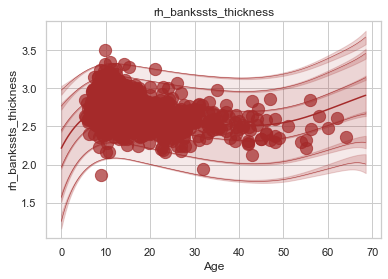

Running IDP 1 rh_caudalanteriorcingulate_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.28222556]), 'Rho': array([0.01122016]), 'pRho': array([0.68126141]), 'SMSE': array([1.2189169]), 'EXPV': array([-0.21438966])}


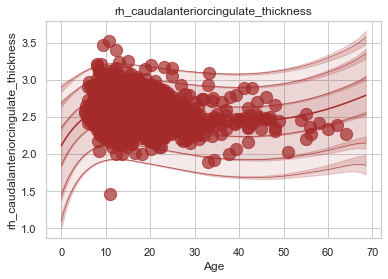

Running IDP 2 rh_caudalmiddlefrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.23326912]), 'Rho': array([0.22565532]), 'pRho': array([4.2788556e-17]), 'SMSE': array([1.46001653]), 'EXPV': array([-0.45747341])}


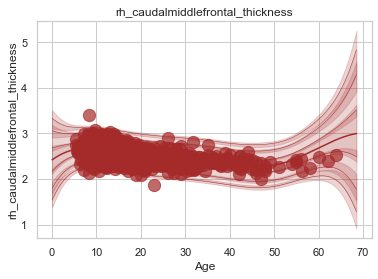

Running IDP 3 rh_cuneus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.19461912]), 'Rho': array([0.41998486]), 'pRho': array([2.34731379e-60]), 'SMSE': array([0.89985071]), 'EXPV': array([0.12815796])}


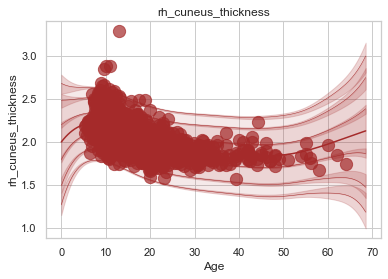

Running IDP 4 rh_entorhinal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.4697559]), 'Rho': array([0.02021468]), 'pRho': array([0.45925178]), 'SMSE': array([1.36122831]), 'EXPV': array([-0.35830217])}


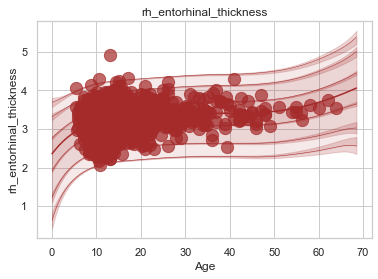

Running IDP 5 rh_fusiform_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.2176712]), 'Rho': array([0.04534259]), 'pRho': array([0.09672347]), 'SMSE': array([1.46995234]), 'EXPV': array([-0.46948033])}


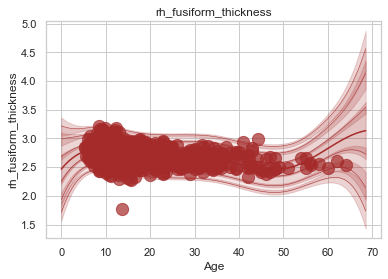

Running IDP 6 rh_inferiorparietal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16477413]), 'Rho': array([0.4187986]), 'pRho': array([5.57659877e-60]), 'SMSE': array([0.86812826]), 'EXPV': array([0.14999369])}


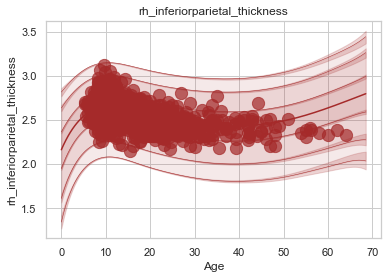

Running IDP 7 rh_inferiortemporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.22647578]), 'Rho': array([0.06766645]), 'pRho': array([0.01310917]), 'SMSE': array([1.27797114]), 'EXPV': array([-0.27045108])}


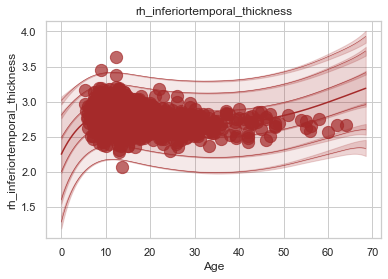

Running IDP 8 rh_isthmuscingulate_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.22933721]), 'Rho': array([0.12989042]), 'pRho': array([1.73746127e-06]), 'SMSE': array([1.11970824]), 'EXPV': array([-0.09841134])}


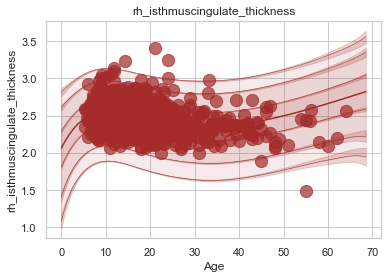

Running IDP 9 rh_lateraloccipital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16113863]), 'Rho': array([0.24245819]), 'pRho': array([1.35634746e-19]), 'SMSE': array([1.01322192]), 'EXPV': array([-0.0104736])}


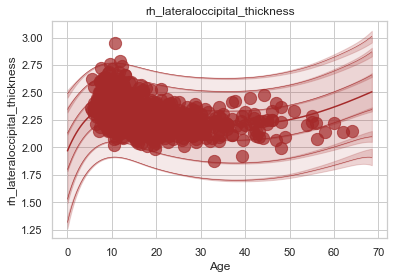

Running IDP 10 rh_lateralorbitofrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.2250869]), 'Rho': array([0.25811509]), 'pRho': array([4.1557443e-22]), 'SMSE': array([1.11500857]), 'EXPV': array([-0.10113157])}


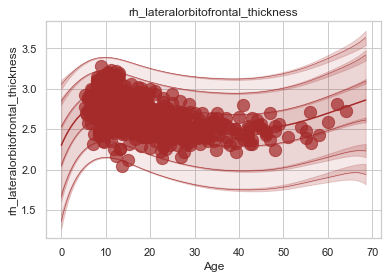

Running IDP 11 rh_lingual_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.18652496]), 'Rho': array([0.32078735]), 'pRho': array([4.36088208e-34]), 'SMSE': array([0.92372258]), 'EXPV': array([0.07660467])}


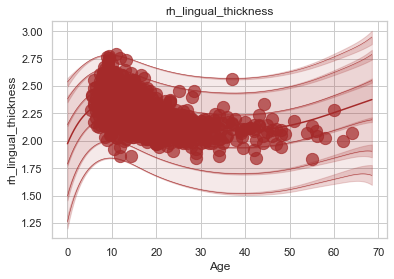

Running IDP 12 rh_medialorbitofrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.218734]), 'Rho': array([0.38966124]), 'pRho': array([2.97985594e-51]), 'SMSE': array([0.98774825]), 'EXPV': array([0.0126519])}


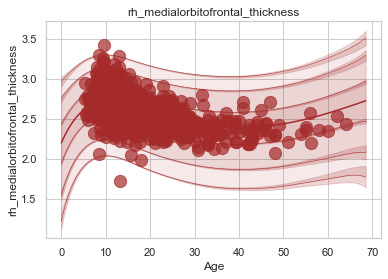

Running IDP 13 rh_middletemporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.23747156]), 'Rho': array([0.07597777]), 'pRho': array([0.0053262]), 'SMSE': array([1.25482774]), 'EXPV': array([-0.22264459])}


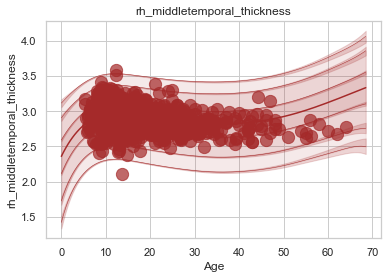

Running IDP 14 rh_parahippocampal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.31260772]), 'Rho': array([-0.04362866]), 'pRho': array([0.11002388]), 'SMSE': array([1.32475431]), 'EXPV': array([-0.31916645])}


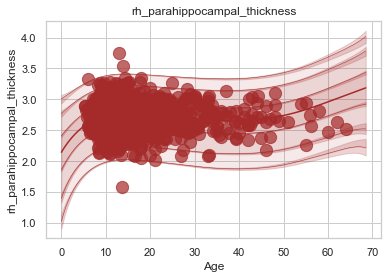

Running IDP 15 rh_paracentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.20672177]), 'Rho': array([0.4230624]), 'pRho': array([2.44276929e-61]), 'SMSE': array([0.95422202]), 'EXPV': array([0.06030559])}


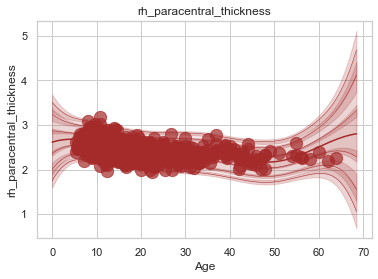

Running IDP 16 rh_parsopercularis_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1920791]), 'Rho': array([0.25767031]), 'pRho': array([4.92696873e-22]), 'SMSE': array([1.03652613]), 'EXPV': array([-0.00958815])}


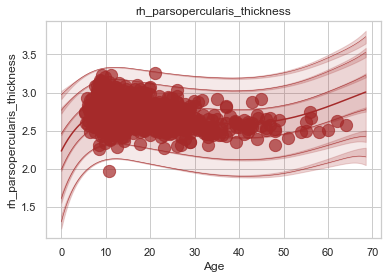

Running IDP 17 rh_parsorbitalis_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.28176916]), 'Rho': array([0.20950444]), 'pRho': array([7.0057389e-15]), 'SMSE': array([1.18869861]), 'EXPV': array([-0.18781624])}


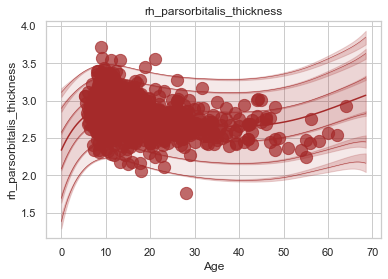

Running IDP 18 rh_parstriangularis_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.2282714]), 'Rho': array([0.35854232]), 'pRho': array([6.26377968e-43]), 'SMSE': array([1.16425159]), 'EXPV': array([-0.15779545])}


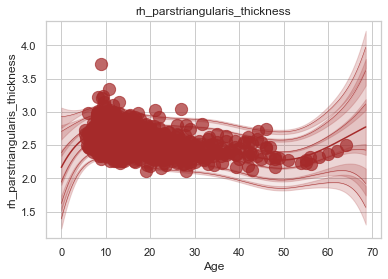

Running IDP 19 rh_pericalcarine_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.21499345]), 'Rho': array([0.18508162]), 'pRho': array([7.17675526e-12]), 'SMSE': array([1.0737718]), 'EXPV': array([-0.07203854])}


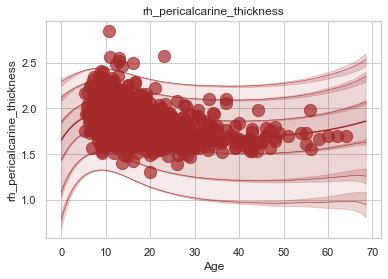

Running IDP 20 rh_postcentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16254709]), 'Rho': array([0.31504032]), 'pRho': array([7.46753069e-33]), 'SMSE': array([0.96321886]), 'EXPV': array([0.06713291])}


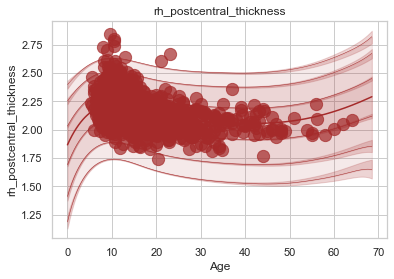

Running IDP 21 rh_posteriorcingulate_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.22173691]), 'Rho': array([0.12408269]), 'pRho': array([4.97827749e-06]), 'SMSE': array([1.28272913]), 'EXPV': array([-0.2768647])}


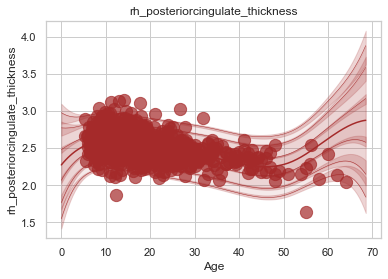

Running IDP 22 rh_precentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.19885989]), 'Rho': array([0.03335441]), 'pRho': array([0.2219251]), 'SMSE': array([1.27493432]), 'EXPV': array([-0.24451383])}


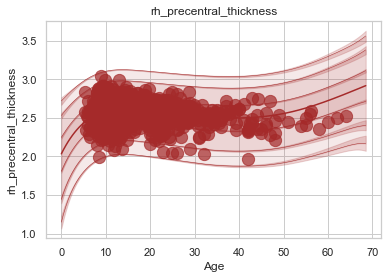

Running IDP 23 rh_precuneus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15118431]), 'Rho': array([0.51027807]), 'pRho': array([2.09591857e-94]), 'SMSE': array([0.76011576]), 'EXPV': array([0.24370956])}


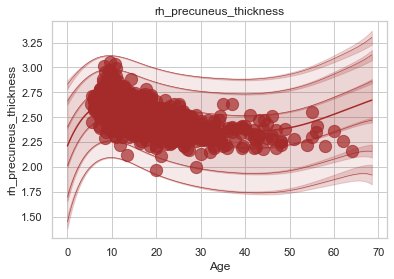

Running IDP 24 rh_rostralanteriorcingulate_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.32940252]), 'Rho': array([0.10169273]), 'pRho': array([0.00018736]), 'SMSE': array([1.26874605]), 'EXPV': array([-0.2683929])}


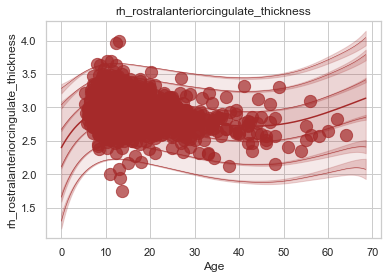

Running IDP 25 rh_rostralmiddlefrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.19857442]), 'Rho': array([0.39875874]), 'pRho': array([7.086303e-54]), 'SMSE': array([0.98453342]), 'EXPV': array([0.01778809])}


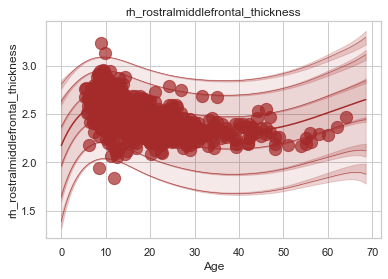

Running IDP 26 rh_superiorfrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.22920105]), 'Rho': array([0.31745339]), 'pRho': array([2.28401764e-33]), 'SMSE': array([1.2971702]), 'EXPV': array([-0.29499337])}


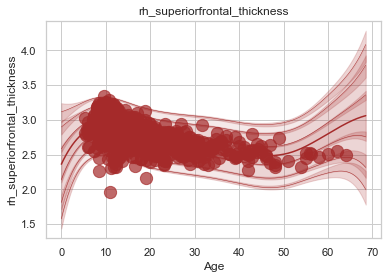

Running IDP 27 rh_superiorparietal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16502947]), 'Rho': array([0.43563849]), 'pRho': array([1.79325967e-65]), 'SMSE': array([0.93672418]), 'EXPV': array([0.0635836])}


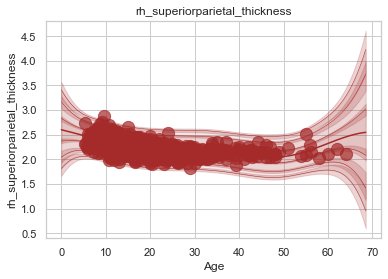

Running IDP 28 rh_superiortemporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.25881521]), 'Rho': array([0.13902027]), 'pRho': array([3.02075824e-07]), 'SMSE': array([1.44197867]), 'EXPV': array([-0.43123337])}


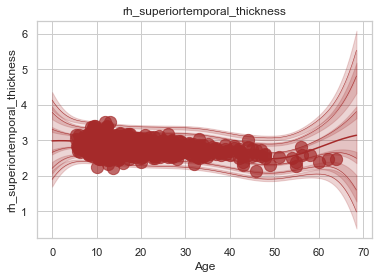

Running IDP 29 rh_supramarginal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.19924368]), 'Rho': array([0.33703226]), 'pRho': array([9.88689538e-38]), 'SMSE': array([1.19049042]), 'EXPV': array([-0.17493106])}


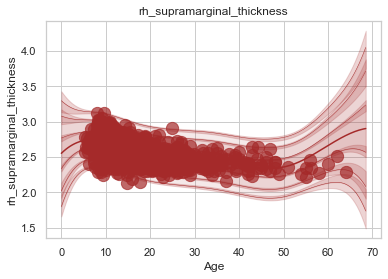

Running IDP 30 rh_frontalpole_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.37739655]), 'Rho': array([0.15813576]), 'pRho': array([5.29234067e-09]), 'SMSE': array([1.29427245]), 'EXPV': array([-0.29292778])}


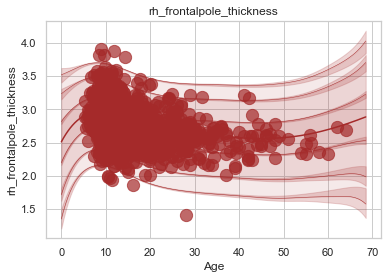

Running IDP 31 rh_temporalpole_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.47417615]), 'Rho': array([0.13451506]), 'pRho': array([7.26712501e-07]), 'SMSE': array([1.23114699]), 'EXPV': array([-0.20280322])}


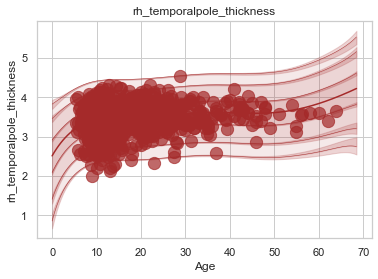

Running IDP 32 rh_transversetemporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.31000126]), 'Rho': array([0.23479138]), 'pRho': array([1.98482587e-18]), 'SMSE': array([1.06146379]), 'EXPV': array([-0.06145301])}


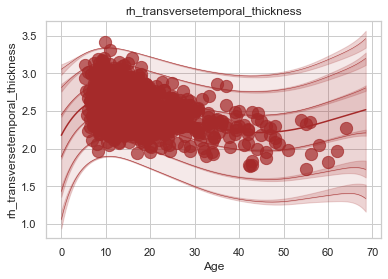

Running IDP 33 rh_insula_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.25799271]), 'Rho': array([-0.06858371]), 'pRho': array([0.01191934]), 'SMSE': array([1.42037859]), 'EXPV': array([-0.41946467])}


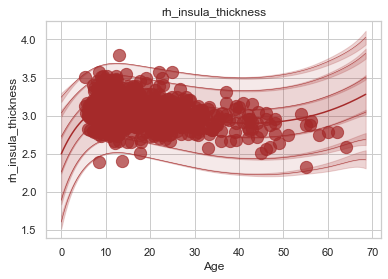

Running IDP 34 lh_bankssts_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.22702898]), 'Rho': array([0.19538867]), 'pRho': array([4.30651052e-13]), 'SMSE': array([1.14642245]), 'EXPV': array([-0.12590199])}


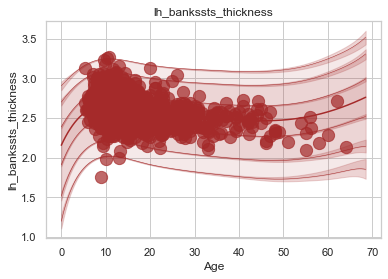

Running IDP 35 lh_caudalanteriorcingulate_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.30087273]), 'Rho': array([0.10748183]), 'pRho': array([7.82368707e-05]), 'SMSE': array([1.10775351]), 'EXPV': array([-0.10142609])}


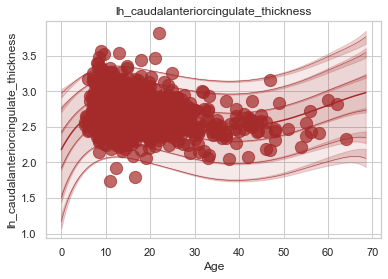

Running IDP 36 lh_caudalmiddlefrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.25005501]), 'Rho': array([0.23849391]), 'pRho': array([5.49856906e-19]), 'SMSE': array([1.59647673]), 'EXPV': array([-0.59573359])}


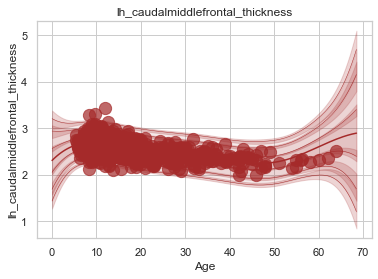

Running IDP 37 lh_cuneus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.19871826]), 'Rho': array([0.42856819]), 'pRho': array([3.99577369e-63]), 'SMSE': array([0.85093555]), 'EXPV': array([0.15442646])}


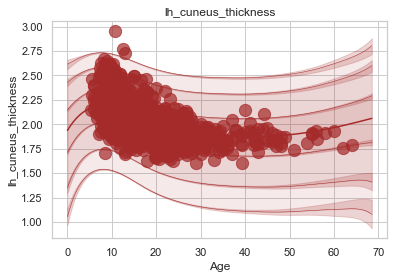

Running IDP 38 lh_entorhinal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.44331406]), 'Rho': array([0.01612141]), 'pRho': array([0.55506212]), 'SMSE': array([1.4031573]), 'EXPV': array([-0.39693495])}


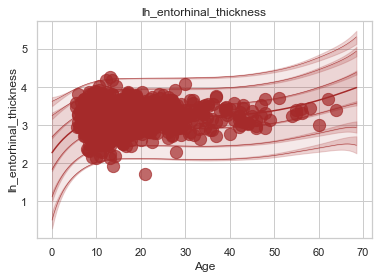

Running IDP 39 lh_fusiform_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.21934521]), 'Rho': array([0.0778709]), 'pRho': array([0.00428575]), 'SMSE': array([1.5416438]), 'EXPV': array([-0.54051791])}


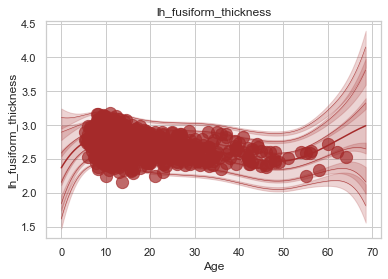

Running IDP 40 lh_inferiorparietal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16319572]), 'Rho': array([0.49435092]), 'pRho': array([1.53881854e-87]), 'SMSE': array([0.79453976]), 'EXPV': array([0.21175841])}


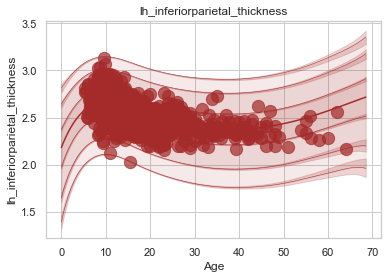

Running IDP 41 lh_inferiortemporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.22638521]), 'Rho': array([0.02139341]), 'pRho': array([0.43348208]), 'SMSE': array([1.34762952]), 'EXPV': array([-0.34187074])}


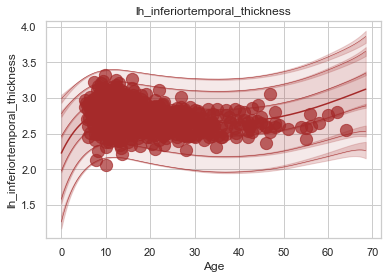

Running IDP 42 lh_isthmuscingulate_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.23315167]), 'Rho': array([0.04864107]), 'pRho': array([0.07475549]), 'SMSE': array([1.15109462]), 'EXPV': array([-0.11775904])}


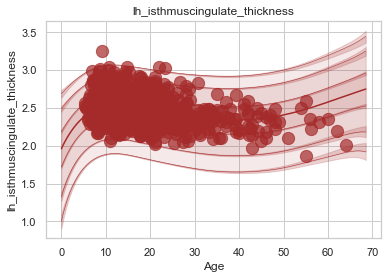

Running IDP 43 lh_lateraloccipital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1609455]), 'Rho': array([0.26296608]), 'pRho': array([6.34794032e-23]), 'SMSE': array([1.0354139]), 'EXPV': array([-0.02551747])}


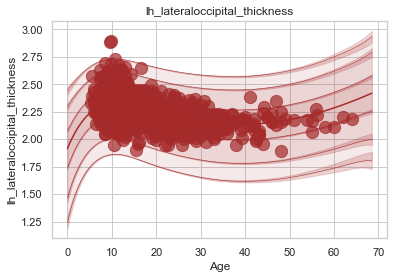

Running IDP 44 lh_lateralorbitofrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.23491814]), 'Rho': array([0.36302476]), 'pRho': array([4.54994905e-44]), 'SMSE': array([1.35591049]), 'EXPV': array([-0.35235725])}


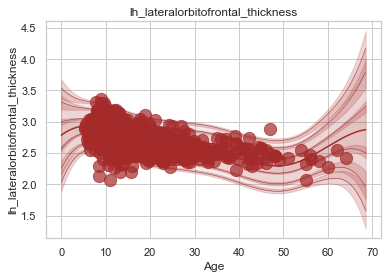

Running IDP 45 lh_lingual_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.18468662]), 'Rho': array([0.46331525]), 'pRho': array([2.8068554e-75]), 'SMSE': array([0.88842615]), 'EXPV': array([0.15209569])}


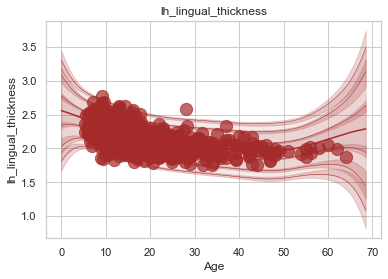

Running IDP 46 lh_medialorbitofrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.23080066]), 'Rho': array([0.35725369]), 'pRho': array([1.3201275e-42]), 'SMSE': array([1.28464149]), 'EXPV': array([-0.26580977])}


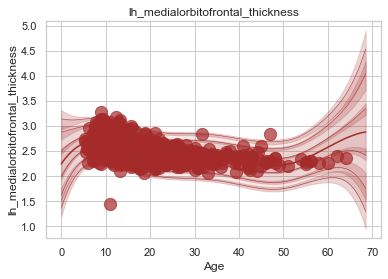

Running IDP 47 lh_middletemporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.23961346]), 'Rho': array([0.1213416]), 'pRho': array([8.05086968e-06]), 'SMSE': array([1.23755203]), 'EXPV': array([-0.21306223])}


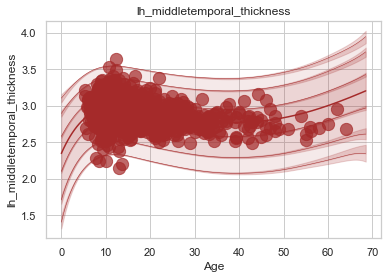

Running IDP 48 lh_parahippocampal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.32746745]), 'Rho': array([0.02609864]), 'pRho': array([0.33928239]), 'SMSE': array([1.15281408]), 'EXPV': array([-0.14917616])}


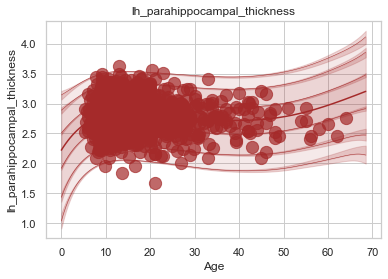

Running IDP 49 lh_paracentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.20992607]), 'Rho': array([0.42879231]), 'pRho': array([3.3737484e-63]), 'SMSE': array([0.93784952]), 'EXPV': array([0.07224791])}


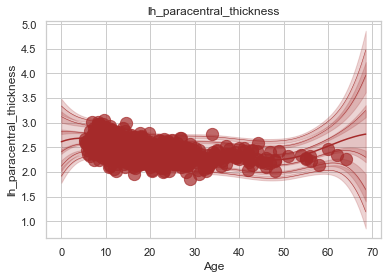

Running IDP 50 lh_parsopercularis_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.20021934]), 'Rho': array([0.27846723]), 'pRho': array([1.1859362e-25]), 'SMSE': array([1.25745178]), 'EXPV': array([-0.25306365])}


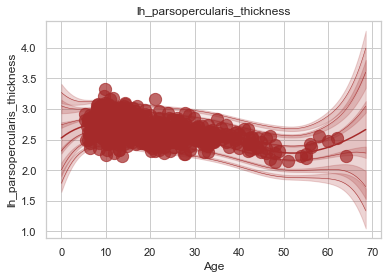

Running IDP 51 lh_parsorbitalis_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.27102555]), 'Rho': array([0.24502179]), 'pRho': array([5.40973665e-20]), 'SMSE': array([1.07071914]), 'EXPV': array([-0.06740811])}


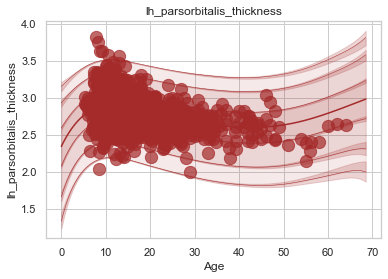

Running IDP 52 lh_parstriangularis_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.21674454]), 'Rho': array([0.35999539]), 'pRho': array([2.69035062e-43]), 'SMSE': array([1.15017764]), 'EXPV': array([-0.15014675])}


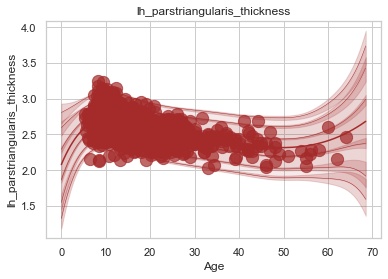

Running IDP 53 lh_pericalcarine_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.22200418]), 'Rho': array([0.26009126]), 'pRho': array([1.94256228e-22]), 'SMSE': array([1.07765467]), 'EXPV': array([-0.06615602])}


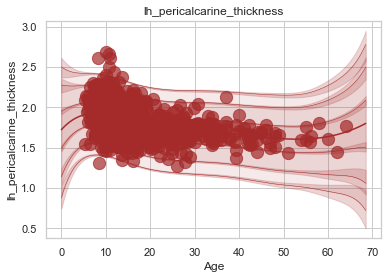

Running IDP 54 lh_postcentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15383474]), 'Rho': array([0.29239973]), 'pRho': array([2.88543031e-28]), 'SMSE': array([0.9730676]), 'EXPV': array([0.04025983])}


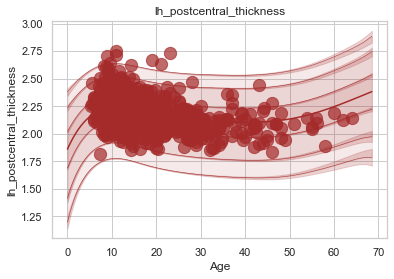

Running IDP 55 lh_posteriorcingulate_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.22027193]), 'Rho': array([0.13394205]), 'pRho': array([8.10902504e-07]), 'SMSE': array([1.1711939]), 'EXPV': array([-0.15806807])}


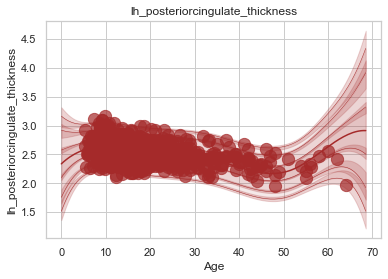

Running IDP 56 lh_precentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.20150684]), 'Rho': array([0.18509879]), 'pRho': array([7.14416901e-12]), 'SMSE': array([1.3753217]), 'EXPV': array([-0.35993088])}


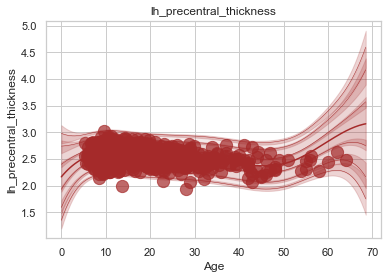

Running IDP 57 lh_precuneus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15662089]), 'Rho': array([0.53093371]), 'pRho': array([6.02245022e-104]), 'SMSE': array([0.75026419]), 'EXPV': array([0.27371494])}


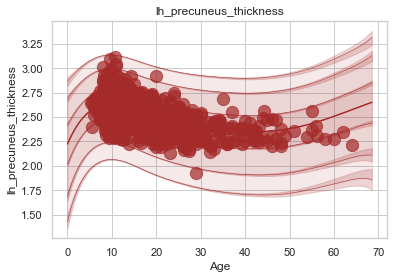

Running IDP 58 lh_rostralanteriorcingulate_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.31025574]), 'Rho': array([0.1643075]), 'pRho': array([1.28179957e-09]), 'SMSE': array([1.13778484]), 'EXPV': array([-0.13761158])}


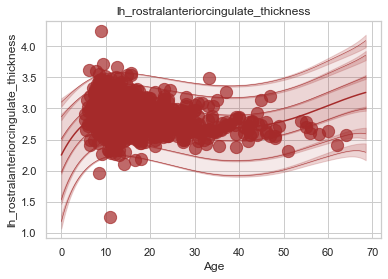

Running IDP 59 lh_rostralmiddlefrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.20654838]), 'Rho': array([0.3022098]), 'pRho': array([3.35170058e-30]), 'SMSE': array([1.09680544]), 'EXPV': array([-0.09405769])}


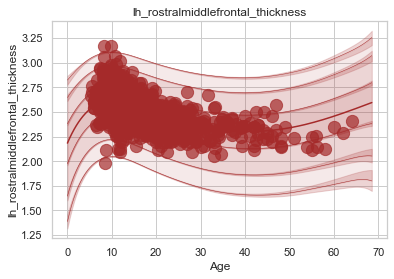

Running IDP 60 lh_superiorfrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.2104697]), 'Rho': array([0.2916854]), 'pRho': array([3.9630011e-28]), 'SMSE': array([1.06941622]), 'EXPV': array([-0.04831635])}


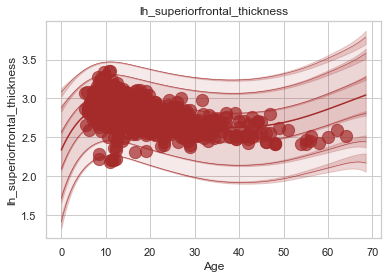

Running IDP 61 lh_superiorparietal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15540163]), 'Rho': array([0.50341543]), 'pRho': array([2.138425e-91]), 'SMSE': array([0.86333883]), 'EXPV': array([0.13670651])}


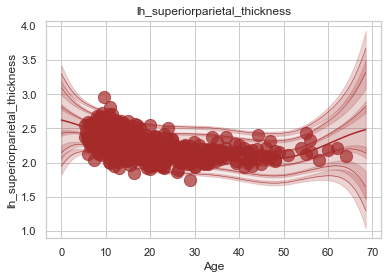

Running IDP 62 lh_superiortemporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.23187141]), 'Rho': array([0.11312836]), 'pRho': array([3.19670371e-05]), 'SMSE': array([1.22749795]), 'EXPV': array([-0.18391728])}


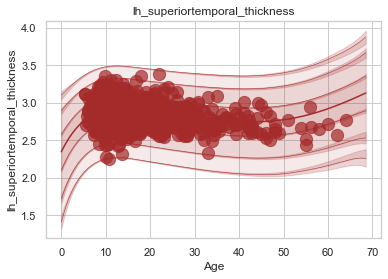

Running IDP 63 lh_supramarginal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.20097237]), 'Rho': array([0.36493639]), 'pRho': array([1.46669679e-44]), 'SMSE': array([1.25922306]), 'EXPV': array([-0.25609947])}


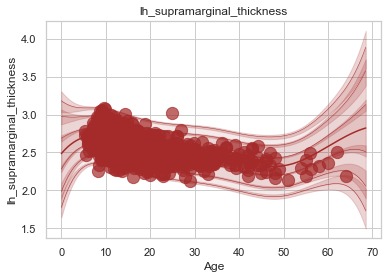

Running IDP 64 lh_frontalpole_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.41104372]), 'Rho': array([0.0930488]), 'pRho': array([0.00063542]), 'SMSE': array([1.39336539]), 'EXPV': array([-0.39332264])}


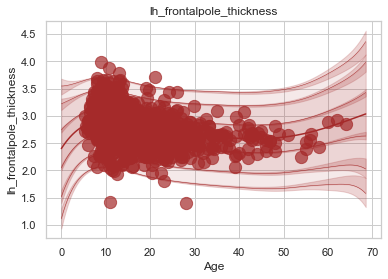

Running IDP 65 lh_temporalpole_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.48255426]), 'Rho': array([-0.00716317]), 'pRho': array([0.79315221]), 'SMSE': array([1.38134437]), 'EXPV': array([-0.36062524])}


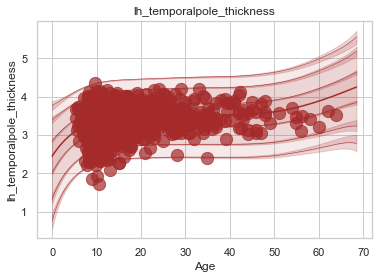

Running IDP 66 lh_transversetemporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.30897723]), 'Rho': array([0.12664152]), 'pRho': array([3.14882633e-06]), 'SMSE': array([1.13284923]), 'EXPV': array([-0.11145379])}


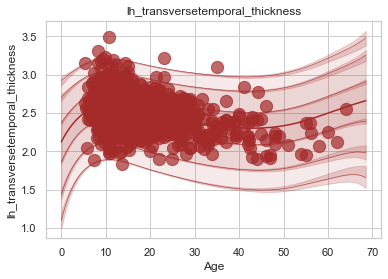

Running IDP 67 lh_insula_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.24113033]), 'Rho': array([-0.0343837]), 'pRho': array([0.20797745]), 'SMSE': array([1.23747099]), 'EXPV': array([-0.2345404])}


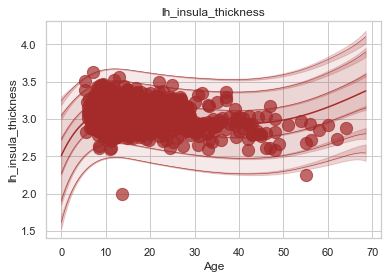

In [487]:
if (sex == 1): 
    clr = 'brown';
else:
    clr = 'red'

# create dummy data for visualisation
print('configuring dummy data ...')
xx = np.arange(xmin, xmax, 0.5)
X0_dummy = np.zeros((len(xx), len(cols_cov)))
X0_dummy[:,0] = xx
X0_dummy[:,1] = sex

# create the design matrix
X_dummy = create_design_matrix(X0_dummy, xmin=xmin, xmax=xmax, 
                               site_ids=None, 
                               all_sites=site_ids_tr
                              )

# save the dummy covariates
cov_file_dummy = os.path.join(out_dir,'cov_bspline_dummy_mean.txt')
np.savetxt(cov_file_dummy, X_dummy)
sns.set(style='whitegrid')

for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)

    # load the true data points
    yhat_te = load_2d(os.path.join(idp_dir, 'yhat_predict.txt'))
    s2_te = load_2d(os.path.join(idp_dir, 'ys2_predict.txt'))
    y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))

    # set up the covariates for the dummy data
    print('Making predictions with dummy covariates (for visualisation)')
    yhat, s2 = predict(cov_file_dummy, 
                       alg = 'blr', 
                       respfile = None, 
                       model_path = os.path.join(idp_dir,'Models'), 
                       outputsuffix = '_dummy')

    # load the normative model
    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 

    # get the warp and warp parameters
    W = nm.blr.warp
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 

    # first, we warp predictions for the true data and compute evaluation metrics
    med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
    med_te = med_te[:, np.newaxis]
    print('metrics:', evaluate(y_te, med_te))

    # then, we warp dummy predictions to create the plots
    med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)

    # extract the different variance components to visualise
    beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
    s2n = 1/beta # variation (aleatoric uncertainty)
    s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)

    # plot the data points
    y_te_rescaled_all = np.zeros_like(y_te)
    for sid, site in enumerate(site_ids_te):
        # plot the true test data points 
        if all(elem in site_ids_tr for elem in site_ids_te):
            # all data in the test set are present in the training set

            # first, we select the data points belonging to this particular site
            idx = np.where(np.bitwise_and(X_te[:,2] == sex, X_te[:,sid+len(cols_cov)+1] !=0))[0]
            if len(idx) == 0:
                print('No data for site', sid, site, 'skipping...')
                continue

            # then directly adjust the data
            idx_dummy = np.bitwise_and(X_dummy[:,1] > X_te[idx,1].min(), X_dummy[:,1] < X_te[idx,1].max())
            y_te_rescaled = y_te[idx] - np.median(y_te[idx]) + np.median(med[idx_dummy])
        else:
            # we need to adjust the data based on the adaptation dataset 

            # first, select the data point belonging to this particular site
            idx = np.where(np.bitwise_and(X_te[:,2] == sex, (df_te['site'] == site).to_numpy()))[0]

            # load the adaptation data
            y_ad = load_2d(os.path.join(idp_dir, 'resp_ad.txt'))
            X_ad = load_2d(os.path.join(idp_dir, 'cov_bspline_ad.txt'))
            idx_a = np.where(np.bitwise_and(X_ad[:,2] == sex, (df_ad['site'] == site).to_numpy()))[0]
            if len(idx) < 2 or len(idx_a) < 2:
                print('Insufficent data for site', sid, site, 'skipping...')
                continue

            # adjust and rescale the data
            y_te_rescaled, s2_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp, 
                                                                   X_ad[idx_a,:], 
                                                                   np.squeeze(y_ad[idx_a]), 
                                                                   Xs=None, 
                                                                   ys=np.squeeze(y_te[idx]))
        # plot the (adjusted) data points
        
        plt.scatter(X_te[idx,1], y_te_rescaled, s=150, color=clr, alpha = 0.7)
        
    # plot the median of the dummy data
    plt.plot(xx, med, clr)

    # fill the gaps in between the centiles
    junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
    plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)

    # make the width of each centile proportional to the epistemic uncertainty
    junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
    junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
    plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.2,color=clr)
    plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.2,color=clr)
    plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.2,color=clr)
    plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.2,color=clr)
    plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.2,color=clr)
    plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.2,color=clr)

    # plot actual centile lines
    plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)

#     plt.ylim(1, 4 )
    plt.xlabel('Age')
    plt.ylabel(idp) 
    plt.title(idp)
#     plt.xlim((5,31))
    plt.savefig(os.path.join(idp_dir, 'centiles_' + str(sex)),  bbox_inches='tight')
    plt.show()

os.chdir(out_dir)

# Export train and test sets

In [488]:
df_tr.to_csv(os.path.join(data_dir, 'Outputs/df_tr.csv'), index = False)
df_te1.to_csv(os.path.join(data_dir, 'Outputs/df_te1.csv'), index = False)
df_te3.to_csv(os.path.join(data_dir, 'Outputs/df_te3.csv'), index = False)